In [1]:
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import gym
import numpy as np
from collections import namedtuple
import random
from matplotlib import pyplot as pl
from IPython.display import clear_output

In [2]:
env = gym.make('Taxi-v2')
eval_env = gym.make('Taxi-v2')
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

In [3]:
input_size = env.observation_space.n
output_size = env.action_space.n
mem_capacity = 20000
batch = 256
lr = 0.001
double_dqn = False
gamma = 0.99
num_steps = 50000
target_update_freq = 500
learn_start = 10000
eval_freq = 300
eval_episodes = 10
eps_decay = 1000
eps_end = 0.1
hidden_layer = 50
l1_regularization = 0
dropout = 0

In [4]:
class DQN_MLP(nn.Module):
    def __init__(self, in_size, out_size, hidden_size, dropout_prob):
        super().__init__()
        self.lin1 = nn.Linear(in_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.lin2 = nn.Linear(hidden_size, out_size)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dropout1(F.relu(self.lin1(x)))
        return self.dropout2(self.lin2(x))

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = np.prod(weight_shape[1:4])
        fan_out = np.prod(weight_shape[2:4]) * weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = weight_shape[1]
        fan_out = weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def add(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        mem_size = len(self.memory)
        batch = random.sample(self.memory, batch_size)
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*batch)
        return batch_state, batch_action, batch_reward, batch_next_state, batch_done

    def __len__(self):
        return len(self.memory)

In [6]:
network = DQN_MLP(input_size, output_size, hidden_layer)
network.apply(init_weights)
target_network = DQN_MLP(input_size, output_size, hidden_layer)
target_network.load_state_dict(network.state_dict())
memory = ReplayBuffer(mem_capacity)

optimizer = optim.Adam(network.parameters(), lr=lr)

In [7]:
average_rewards = []
avg_rew_steps = []
losses = []
losses_steps = []

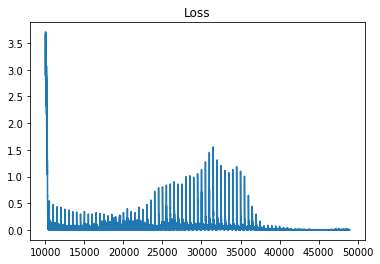

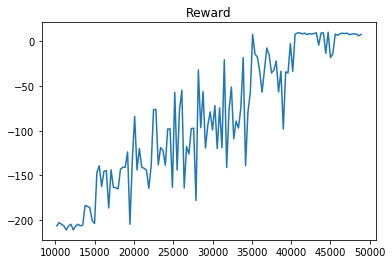

Step: 49200 Avg reward: 5.2
Step: 49500 Avg reward: 8.0
Step: 49800 Avg reward: 9.2


In [8]:
done = True
for step in range(num_steps):
    if done:
        state_idx = env.reset()
        state = torch.zeros([input_size], dtype=torch.float32)
        state[state_idx] = 1
        
    action = network(state.unsqueeze(0)).max(1)[1].item()
    eps = max((eps_decay - step + learn_start) / eps_decay, eps_end)
    if random.random() < eps:
        action = env.action_space.sample()
    
    next_state_idx, reward, done, _ = env.step(action)
    next_state = torch.zeros([input_size], dtype=torch.float32)
    next_state[next_state_idx] = 1
    # Done due to timeout is a non-markovian property. This is an artifact which we would not like to learn from.
    if not (done and reward < 0):
        memory.add(state, action, reward, next_state, not done)
    state = next_state
    
    if step > learn_start:
        batch_state, batch_action, batch_reward, batch_next_state, not_done_mask = memory.sample(batch)
        
        batch_state = torch.stack(batch_state)
        batch_next_state = torch.stack(batch_next_state)
        batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(-1)
        batch_reward = torch.tensor(batch_reward, dtype=torch.float32).unsqueeze(-1)
        not_done_mask = torch.tensor(not_done_mask, dtype=torch.float32).unsqueeze(-1)
        
        current_Q = network(batch_state).gather(1, batch_action)
        
        with torch.no_grad():
            if double_dqn:
                next_state_actions = network(batch_next_state).max(1, keepdim=True)[1]
                next_Q = target_network(batch_next_state).gather(1, next_state_actions)
            else:
                next_Q = target_network(batch_next_state).max(1, keepdim=True)[0]
            target_Q = batch_reward + (gamma * next_Q) * not_done_mask
            
            
        loss = F.smooth_l1_loss(current_Q, target_Q)
        all_params = torch.cat([x.view(-1) for x in model.parameters()])
        loss += l1_regularization * torch.norm(all_params, 1)
        
        optimizer.zero_grad()
        loss.backward()
#         for param in network.parameters():
#             param.grad.data.clamp_(-1, 1)
        optimizer.step()
        losses.append(loss.item())
        losses_steps.append(step)
    
    if step % target_update_freq == 0:
        target_network.load_state_dict(network.state_dict())
    
    if step % eval_freq == 0 and step > learn_start:
        network.eval()
        total_reward = 0
        for eval_ep in range(eval_episodes):
            eval_state_idx = eval_env.reset()
            while True:
                eval_state = torch.zeros([input_size], dtype=torch.float32)
                eval_state[eval_state_idx] = 1

                action = network(eval_state.unsqueeze(0)).max(1)[1].item()
                if random.random() < 0.01:
                    action = random.randrange(output_size)
                eval_state_idx, reward, done, _ = eval_env.step(action)
                
                total_reward += reward
                if done:
                    break
        network.train()
        
        average_reward = total_reward * 1.0 / eval_episodes
        average_rewards.append(average_reward)
        avg_rew_steps.append(step)
        print('Step: ' + str(step) + ' Avg reward: ' + str(average_reward))
    
    if step > learn_start and len(losses) > 0 and len(average_rewards) > 0 and step % 1000 == 0:
        clear_output()
        pl.plot(losses_steps, losses)
        pl.title('Loss')
        pl.show()
        pl.plot(avg_rew_steps, average_rewards)
        pl.title('Reward')
        pl.show()

In [13]:
torch.save(network.state_dict(), 'dqn')

In [10]:
eval_state_idx = eval_env.reset()
while True:
    eval_env.render()
    eval_state = torch.zeros([input_size], dtype=torch.float32)
    eval_state[eval_state_idx] = 1

    q_vals = network(eval_state.unsqueeze(0))
    print(q_vals)
    action = q_vals.max(1)[1].item()
    if random.random() < 0.1:
        action = random.randrange(output_size)
    eval_state_idx, reward, done, _ = eval_env.step(action)

    if done:
        break
eval_env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

tensor([[ 6.3350,  5.1652,  6.3403,  5.1092, -1.5061, -3.2601]])
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
tensor([[ 7.4364,  5.3289,  5.3318,  5.3518, -1.5572, -1.8523]])
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
tensor([[ 8.5512,  6.4369,  6.4177,  6.3368, -1.5429, -1.5469]])
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
tensor([[ 9.6341,  7.3952,  7.4557,  8.5454, -0.4541, -0.4568]])
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
tensor([[  9.6308,   8.5540,   8.5426,   8.7640,  10.7381,   0.6258]])
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
tensor([[ 10.8310,  11.8578,   9.6306,  10.7588,   1.8422,   8.4260]])
+---------+
|R: | : :G|
| : : : : |
| : : :

In [12]:
rews = []
for _ in range(10):
    eval_state_idx = eval_env.reset()
    rew = 0
    while True:
        eval_state = torch.zeros([input_size], dtype=torch.float32)
        eval_state[eval_state_idx] = 1

        q_vals = network(eval_state.unsqueeze(0))
        action = q_vals.max(1)[1].item()
        if random.random() < 0.1:
            action = random.randrange(output_size)
        eval_state_idx, reward, done, _ = eval_env.step(action)

        rew += reward
        
        if done:
            break
    rews.append(rew)
print('Average reward: ' + str(np.mean(rews)))
print('Variance: ' + str(np.var(rews)))

Average reward: 4.8
Variance: 30.360000000000007
